In [74]:
import pandas as pd
import os
import numpy as np

%matplotlib inline
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import seaborn as sns
import scipy.stats as stats
from patsy import dmatrices
import statsmodels.api as sm

In [75]:
################################################################
#### load in results based on raw anatomical ROIs

import cPickle
## path to non-RFE raw differentiation analysis by condition
path_to_rawdiff = '/home/jefan/neurosketch/prepost_differentiation_by_condition.pkl'

## Load in saved npy
## columns are: Tradiffpost,Tradiffpre,Condiffpost,Condiffpre
## where: Tradiffpost = trabtw_mean_post - trawit_mean_post 
## generated by compare_btw_wit_cond_similarity_across_runs in prepostRSA.ipynb
# with open('/home/jefan/neurosketch/prepost_differentiation_by_condition.pkl', 'rb') as f:
#     prepost_diff = cPickle.load(f, encoding='latin1') 
subj = ['0110171_neurosketch', '0110172_neurosketch', '0111171_neurosketch', '0112171_neurosketch', '0112172_neurosketch', '0112173_neurosketch', '0113171_neurosketch', '0115172_neurosketch', '0115174_neurosketch', '0117171_neurosketch', '0118171_neurosketch', '0118172_neurosketch', '0119171_neurosketch', '0119172_neurosketch', '0119173_neurosketch', '0119174_neurosketch', '0120171_neurosketch', '0120172_neurosketch', '0120173_neurosketch', '0123171_neurosketch', '0123173_neurosketch', '0124171_neurosketch', '0125171_neurosketch', '0125172_neurosketch', '1121161_neurosketch', '1130161_neurosketch', '1201161_neurosketch', '1202161_neurosketch', '1203161_neurosketch', '1206161_neurosketch', '1206162_neurosketch', '1206163_neurosketch', '1207162_neurosketch']
ROIS = ['V1','fusiform','IT','LOC','occitemp']
CONDS = ['trained_pre','trained_post','control_pre','control_post']
headers = []
for cond in CONDS:
    for roi in ROIS:
        headers.append('{}_{}'.format(cond,roi))
        
prepost_diff = np.load('/home/jefan/neurosketch/prepost_differentiation_by_condition.npy')    
    
Tradiffpost = prepost_diff[0]    
Tradiffpre = prepost_diff[1]
Condiffpost = prepost_diff[2]
Condiffpre = prepost_diff[3]

MAT = np.hstack((Tradiffpre.transpose(),Tradiffpost.transpose(),Condiffpre.transpose(),Condiffpost.transpose()))

df = pd.DataFrame(data=MAT,columns = headers)
df.to_csv('neural_changes_by_roi_and_subject_raw_anatomical.csv')

################################################################
#### load in results based on RFE applied within ROIs
X0 = pd.read_csv('neural_changes_by_roi_and_subject_with_identifier.csv')
X1 = pd.read_csv('neural_changes_by_roi_and_subject_run_1.csv')
X2 = pd.read_csv('neural_changes_by_roi_and_subject_run_2.csv')
# combine run1, run2 versions
X3 = pd.concat((X1, X2)) 
X3 = X3.groupby(X3.index).mean()
## results based on raw anatomical
X4 = pd.read_csv('neural_changes_by_roi_and_subject_raw_anatomical.csv')

################################################################
######## WHICH NEURAL CHANGE RESULTS MATRIX ######## ########
################################################################
# X3 = define the main neural results matrix to be the combination of run1 and run2 results
# X4 = use results based on raw anatomical ROIs
X = X4
################################################################
################################################################


# add subj ID column
if X.shape==X4.shape:
    subj = subj
else:    
    subj = X0.subj.values
X = X.assign(subj=pd.Series(subj).values)

# X.rename(columns={'IDs': 'subj'}, inplace=True)

# filter outlier
filter_outlier = 1
if filter_outlier:
    Xo = X[X.subj!='0115172_neurosketch']
    X = Xo

In [76]:
neural_subs = X.subj.values

In [77]:
diffscore_V1 = (X['trained_post_V1']-X['trained_pre_V1']) - (X['control_post_V1']-X['control_pre_V1']) 
diffscore_fusiform = (X['trained_post_fusiform']-X['trained_pre_fusiform']) - (X['control_post_fusiform']-X['control_pre_fusiform'])
diffscore_LOC = (X['trained_post_LOC']-X['trained_pre_LOC']) - (X['control_post_LOC']-X['control_pre_LOC'])
diffscore_IT = (X['trained_post_IT']-X['trained_pre_IT']) - (X['control_post_IT']-X['control_pre_IT'])
diffscore_occitemp = (X['trained_post_occitemp']-X['trained_pre_occitemp']) - (X['control_post_occitemp']-X['control_pre_occitemp'])
diffscore_IT_V1 = diffscore_IT - diffscore_V1

In [78]:
# W = pd.read_csv('sketch_recognizability_timecourse_early_vs_late.csv')
W = pd.read_csv('sketch_recognizability_timecourse_initial10_vs_final10.csv')
Ws = pd.read_csv('sketch_similarity_timecourse_within_run.csv')

In [79]:
draw_subs = W.subj.values

In [80]:
intersect_subs = np.intersect1d(neural_subs,draw_subs)
print len(intersect_subs)

32


In [81]:
draw_early = []
draw_late = []
within_run = []
for index,row in X.iterrows():
    sub = row['subj']
    draw_early.append(W[W['subj']==sub]['early_score'].values[0])
    draw_late.append(W[W['subj']==sub]['late_score'].values[0]) 
    within_run.append(Ws[Ws['subj']==sub]['runwise_similarity_change'].values[0]) 
draw_change = np.array(draw_late) - np.array(draw_early)

In [82]:
## assign convenience columns to X matrix
X = X.assign(within_run=pd.Series(within_run).values)
X = X.assign(draw_early=pd.Series(draw_early).values)
X = X.assign(draw_late=pd.Series(draw_late).values)
X = X.assign(draw_change=pd.Series(draw_change).values)
X = X.assign(diffscore_V1=pd.Series(diffscore_V1).values)
X = X.assign(diffscore_fusiform=pd.Series(diffscore_fusiform).values)
X = X.assign(diffscore_LOC=pd.Series(diffscore_LOC).values)
X = X.assign(diffscore_IT=pd.Series(diffscore_IT).values)
X = X.assign(diffscore_IT_V1=pd.Series(diffscore_IT_V1).values)
X = X.assign(diffscore_occitemp=pd.Series(diffscore_occitemp).values)

(0.052261644878730876, 0.77635793959047783)
SpearmanrResult(correlation=0.10345019123785824, pvalue=0.57313860940462602)


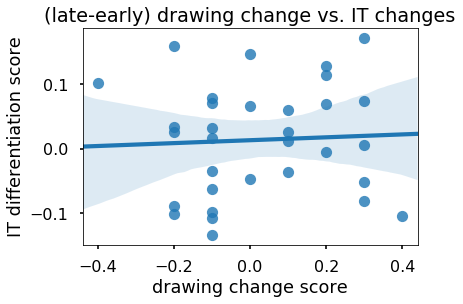

In [83]:
### overall recognizability (classifier accuracy) difference between first 20 drawings and final 20 drawings
sns.set_context('poster')
sns.regplot(x="draw_change",y="diffscore_IT",data=X)
plt.title('(late-early) drawing change vs. IT changes')
plt.ylabel('IT differentiation score')
plt.xlabel('drawing change score')
# plt.xlim([-0.4,0.4])
# plt.ylim([-0.6,0.6])
print stats.pearsonr(diffscore_IT,draw_change)
print stats.spearmanr(diffscore_IT,draw_change)

IT changes
(-0.21623993927325036, 0.23455865238178733)
SpearmanrResult(correlation=-0.19431714350337687, pvalue=0.28656396852801314)
LOC changes
(-0.29151143906892185, 0.10548816456928811)
SpearmanrResult(correlation=-0.31934006036120988, pvalue=0.07481988799121353)
V1 changes
(-0.23791820875597844, 0.18977524318740732)
SpearmanrResult(correlation=-0.31182401990494718, pvalue=0.082320239797413639)
Occipitotemporal changes
(-0.36959940895786358, 0.037346845847766472)
SpearmanrResult(correlation=-0.32905591753637869, pvalue=0.065922003812997912)


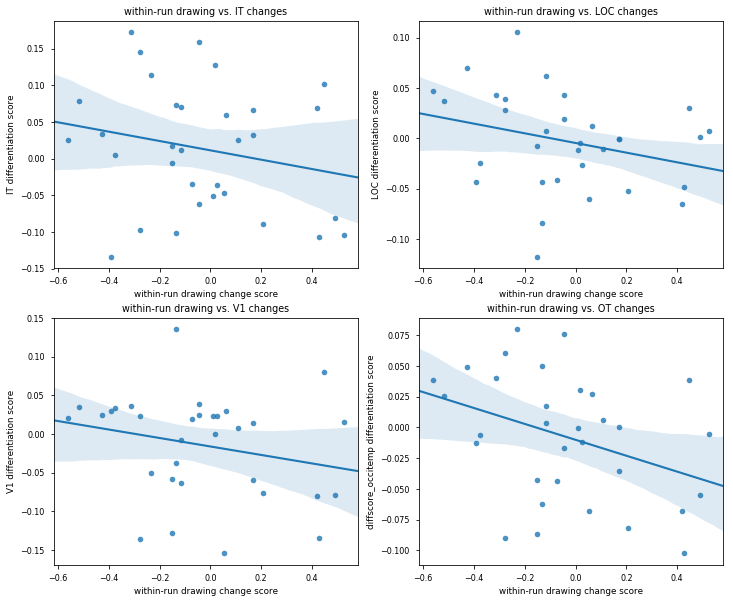

In [84]:
### within_run: ranges from (-1, 1). negative values indicate decreasing similarity across trials within-run. 
sns.set_context('paper')
fig = plt.figure(figsize=(12,10))

plt.subplot(221)
sns.regplot(x="within_run",y="diffscore_IT",data=X)
plt.title('within-run drawing vs. IT changes')
plt.ylabel('IT differentiation score')
plt.xlabel('within-run drawing change score')
print 'IT changes'
print stats.pearsonr(diffscore_IT,within_run)
print stats.spearmanr(diffscore_IT,within_run)

plt.subplot(222)
sns.regplot(x="within_run",y="diffscore_LOC",data=X)
plt.title('within-run drawing vs. LOC changes')
plt.ylabel('LOC differentiation score')
plt.xlabel('within-run drawing change score')
print 'LOC changes'
print stats.pearsonr(diffscore_LOC,within_run)
print stats.spearmanr(diffscore_LOC,within_run)

plt.subplot(223)
sns.regplot(x="within_run",y="diffscore_V1",data=X)
plt.title('within-run drawing vs. V1 changes')
plt.ylabel('V1 differentiation score')
plt.xlabel('within-run drawing change score')
print 'V1 changes'
print stats.pearsonr(diffscore_V1,within_run)
print stats.spearmanr(diffscore_V1,within_run)

plt.subplot(224)
sns.regplot(x="within_run",y="diffscore_occitemp",data=X)
plt.title('within-run drawing vs. OT changes')
plt.ylabel('diffscore_occitemp differentiation score')
plt.xlabel('within-run drawing change score')
print 'Occipitotemporal changes'
print stats.pearsonr(diffscore_occitemp,within_run)
print stats.spearmanr(diffscore_occitemp,within_run)

(-0.030184623565056749, 0.86973609880113123)
SpearmanrResult(correlation=-0.050229148415023822, pvalue=0.7848482217874454)


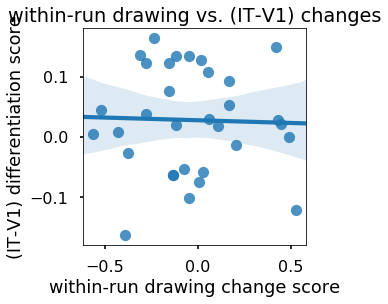

In [85]:
### within_run: ranges from (-1, 1). negative values indicate decreasing similarity across trials within-run.
fig = plt.figure(figsize=(4,4))
sns.set_context('poster')
sns.regplot(x="within_run",y="diffscore_IT_V1",data=X)
plt.title('within-run drawing vs. (IT-V1) changes')
plt.ylabel('(IT-V1) differentiation score')
plt.xlabel('within-run drawing change score')
print stats.pearsonr(diffscore_IT_V1,within_run)
print stats.spearmanr(diffscore_IT_V1,within_run)

(-0.43735855632943887, 0.012309122512124845)
SpearmanrResult(correlation=-0.43153071302542367, pvalue=0.013660329965234693)


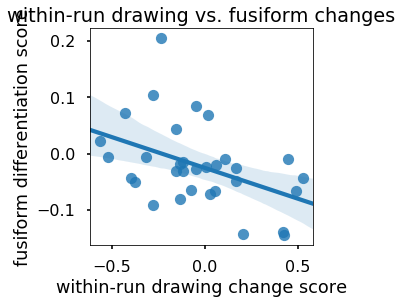

In [94]:
### within_run: ranges from (-1, 1). negative values indicate decreasing similarity across trials within-run.
fig = plt.figure(figsize=(4,4))
sns.set_context('poster')
sns.regplot(x="within_run",y="diffscore_fusiform",data=X)
plt.title('within-run drawing vs. fusiform changes')
plt.ylabel('fusiform differentiation score')
plt.xlabel('within-run drawing change score')
print stats.pearsonr(diffscore_fusiform,within_run)
print stats.spearmanr(diffscore_fusiform,within_run)

IT vs. V1 change mean = 0.0278473353372
Ttest_1sampResult(statistic=1.8191652829342364, pvalue=0.078557699886105323)
IT change mean = 0.0137995007439
Ttest_1sampResult(statistic=0.90725306925303817, pvalue=0.37127178927050386)
fusiform change mean = -0.0212556260778
Ttest_1sampResult(statistic=-1.6469239301390357, pvalue=0.10967530945968211)


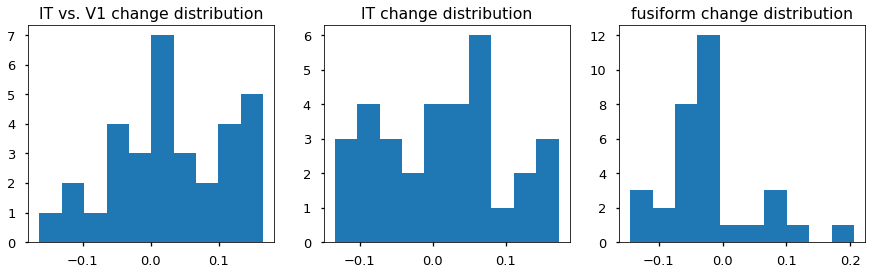

In [102]:
sns.set_context('talk')
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.title('IT vs. V1 change distribution')
h = plt.hist(diffscore_IT-diffscore_V1)
print 'IT vs. V1 change mean = ' + str(np.mean(diffscore_IT-diffscore_V1))
print stats.ttest_1samp(diffscore_IT-diffscore_V1,0)

plt.subplot(132)
h = plt.hist(diffscore_IT)
plt.title('IT change distribution')
print 'IT change mean = ' + str(np.mean(diffscore_IT))
print stats.ttest_1samp(diffscore_IT,0)

plt.subplot(133)
h = plt.hist(diffscore_fusiform)
plt.title('fusiform change distribution')
print 'fusiform change mean = ' + str(np.mean(diffscore_fusiform))
print stats.ttest_1samp(diffscore_fusiform,0)

In [96]:
## restructure dataframe to make it friendly for statsmodels
phase = np.array([0]*len(X)+[1]*len(X))
subjs2 = np.array(np.tile(X.subj.values,2))
trained_V1 = np.hstack((X['trained_pre_V1'].values, X['trained_post_V1'].values))
trained_fusiform = np.hstack((X['trained_pre_fusiform'].values, X['trained_post_fusiform'].values))
trained_LOC = np.hstack((X['trained_pre_LOC'].values, X['trained_post_LOC'].values))
trained_IT = np.hstack((X['trained_pre_IT'].values, X['trained_post_IT'].values))
trained_occitemp = np.hstack((X['trained_pre_occitemp'].values, X['trained_post_occitemp'].values))

control_V1 = np.hstack((X['control_pre_V1'].values, X['control_post_V1'].values))
control_fusiform = np.hstack((X['control_pre_fusiform'].values, X['control_post_fusiform'].values))
control_LOC = np.hstack((X['control_pre_LOC'].values, X['control_post_LOC'].values))
control_IT = np.hstack((X['control_pre_IT'].values, X['control_post_IT'].values))
control_occitemp = np.hstack((X['control_pre_occitemp'].values, X['control_post_occitemp'].values))

diff_V1 = trained_V1-control_V1
diff_fusiform = trained_fusiform-control_fusiform
diff_LOC = trained_LOC-control_LOC
diff_IT = trained_IT-control_IT
diff_occitemp = trained_occitemp-control_occitemp
diff_IT_V1 = diff_IT - diff_V1

In [97]:
Y = pd.DataFrame([subjs2,phase,trained_V1,trained_fusiform,trained_LOC,trained_IT,
                control_V1,control_fusiform,control_LOC,control_IT,
                diff_V1,diff_fusiform,diff_LOC,diff_IT,diff_IT_V1,diff_occitemp])
Y = Y.transpose()
Y.columns = ['subj','phase','trained_V1','trained_fusiform','trained_LOC','trained_IT',
            'control_V1','control_fusiform','control_LOC','control_IT',
            'diff_V1','diff_fusiform','diff_LOC','diff_IT','diff_IT_V1','diff_occitemp']

In [98]:
Y['phase'] = Y['phase'].astype(int)
Y['phase_ord'] = pd.Categorical(Y.phase).codes
Y['diff_IT'] = Y['diff_IT'].astype(float)
Y['diff_V1'] = Y['diff_V1'].astype(float)
Y['diff_fusiform'] = Y['diff_fusiform'].astype(float)
Y['diff_occitemp'] = Y['diff_occitemp'].astype(float)
Y['diff_LOC'] = Y['diff_LOC'].astype(float)
Y['diff_IT_V1'] = Y['diff_IT_V1'].astype(float)

In [99]:
import statsmodels.formula.api as smf
md = smf.mixedlm("diff_fusiform ~ C(phase)", Y, groups=Y['subj'])
mdf = md.fit()
mdf.summary()

/home/jefan/.local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: diff_fusiform
No. Observations: 64      Method:             REML         
No. Groups:       32      Scale:              0.0027       
Min. group size:  2       Likelihood:         87.5314      
Max. group size:  2       Converged:          Yes          
Mean group size:  2.0                                      
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.017    0.010  1.744 0.081 -0.002  0.037
C(phase)[T.1]    -0.021    0.013 -1.647 0.100 -0.047  0.004
groups RE         0.000    0.013                           
===========================================================

"""

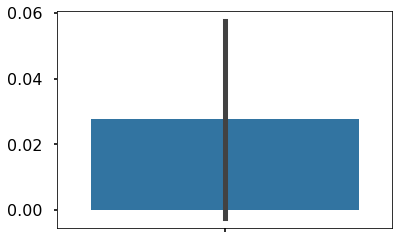

In [93]:
_y = (Y[Y['phase']==1].diff_IT.values - Y[Y['phase']==0].diff_IT.values) - \
    (Y[Y['phase']==1].diff_V1.values - Y[Y['phase']==0].diff_V1.values)
sns.barplot(y=_y)

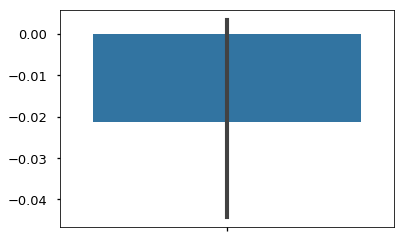

In [103]:
_y = (Y[Y['phase']==1].diff_fusiform.values - Y[Y['phase']==0].diff_fusiform.values) 
sns.barplot(y=_y)